# Gaussian Processes for Orientation Preference Maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from opm import make_opm, plot_opm, plot_amplitude_map, get_indices, calculate_map
from pinwheels import plot_pinwheels
from response import response, create_stimuli, compute_responses
from kernels import mexican_hat_kernel
from gp import GaussianProcessOPM, prior_covariance
from match_radial_component import radial_component, match_radial_component

In [2]:
get_indices((3,2))

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1]])

## Ground truth map

For computational simplicity, we create an OPM of lower dimensionality. Additionally, we need the (x,y) indices for every pixel.

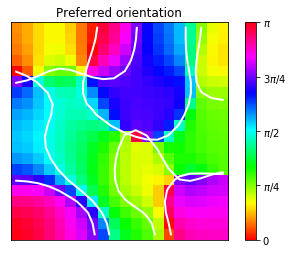

In [22]:
size = (20,20)

n = size[0] * size[1]
d = 3

# ground truth opm
m = make_opm(size=size, sigma=3., k=2., alpha=2.)

f, ax = plot_opm(m)
plot_pinwheels(m, ax)

plt.show()

idx = get_indices(size)

## Responses
The responses are computed exactly the same way as before.

In [23]:
# compute responses
contrasts = [1.]
orientations = [i * np.pi / 4 - np.pi/2 for i in range(4)]
repetitions = 16

V = create_stimuli(contrasts, orientations, repetitions)

# number of trials
N_cond = V.shape[0]
N = N_cond * V.shape[1]

R = compute_responses(m, contrasts, orientations, repetitions, sigma=0.1)

V_cov = V.reshape((N,d)).T @ V.reshape((N,d))
np.allclose(V_cov, N / 2 * np.eye(d))
(V_cov).round(5)

array([[32.,  0., -0.],
       [ 0., 32., -0.],
       [-0., -0., 32.]])

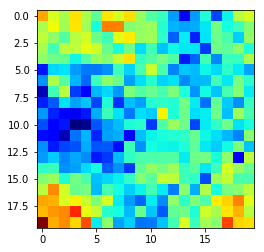

In [24]:
R.shape
res = R.reshape((N,-1))
plt.imshow(res[1].reshape(size), cmap='jet')

In [25]:
V.shape

(4, 16, 3)

## Gaussian Process Posterior

The covariance and mean of the Gaussian process posterior can be obtained as:

$ \Sigma_{post}^{-1} = K_m^{-1} + (\sum_i v_i v_i^T) \otimes \Sigma_{\epsilon}^{-1}$

$ \mu_{post} = \Sigma_{post} (\mathbb{I}_d \otimes \Sigma_{\epsilon}^{-1}) \sum_i v_i \otimes \mathbf{r}_i $

In [26]:
gp = GaussianProcessOPM(size=size, prior_method='icd', prior_rank=200)

In [27]:
mu_post = gp.fit(stimuli=V, responses=R, noise=np.eye(n) * 0.1, verbose=True)

*** Estimating prior hyperparameters ***
{'sigma': 2.1772513792444133, 'alpha': 1.5231613254521084}
*** Fitting prior ***
*** Fitting posterior ***


In [28]:
mu_post

array([[-0.00703918],
       [-0.00648673],
       [-0.00532939],
       ...,
       [ 0.02690875],
       [ 0.0267219 ],
       [ 0.02307787]])

In [29]:
K_post = gp.K_post
noise_cov = np.eye(n) * 0.1

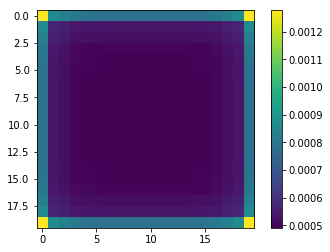

In [33]:
plt.imshow(np.diag(K_post).reshape((d, *size))[2])
plt.colorbar()

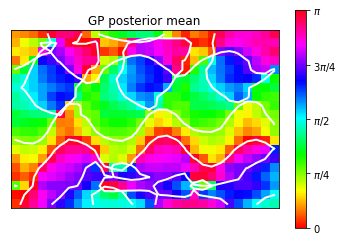

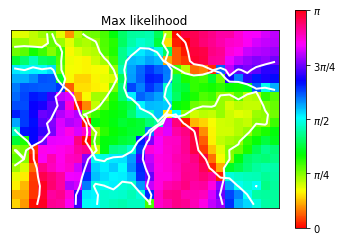

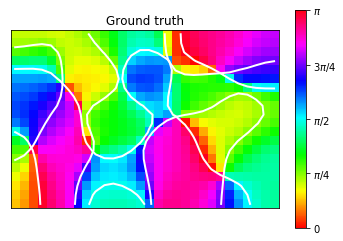

In [12]:
mu = mu_post.reshape(d, *size)
result = mu[0] + 1j * mu[1]
f, ax = plot_opm(result, title='GP posterior mean')
plot_pinwheels(result, ax)
plt.show()

ml = calculate_map(R, V).reshape(n*d, 1)
ml = ml.reshape(d, *size)
m_hat = ml[0] + 1j * ml[1]
f, ax = plot_opm(m_hat, title='Max likelihood')
plot_pinwheels(m_hat, ax)
plt.show()

f, ax = plot_opm(m, title='Ground truth')
plot_pinwheels(m, ax)
plt.show()